In [1]:
import pandas as pd 

In [2]:
X0=pd.read_parquet('X_t0.parquet')
X1=pd.read_parquet('X_t1.parquet')
X2=pd.read_parquet('X_t2.parquet')
y0=pd.read_parquet('y_t0.parquet')
y1=pd.read_parquet('y_t1.parquet')

In [3]:
!pip install optuna



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Configurar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

In [5]:
# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

In [8]:
pipeline = Pipeline([
    ('Preprocessing', preprocessor),
    ('XGBoost', XGBClassifier())
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['avg_gas_paid_per_tx_eth',
                                                   'avg_risk_factor',
                                                   'avg_weighted_risk_factor',
                                                   'borrow_amount_avg_eth',
                                                   'borrow_amount_sum_eth',
                                                   'borrow_count',
                                                   'borrow_repay_diff_eth',
                                                   'deposit_amount_sum_eth',
                                                   'deposit_count',
                                                   'incoming_tx_avg_eth',
                                                   'incoming_tx_count',
                                                   'incoming_tx_sum...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [9]:
X0p = preprocessor.fit_transform(X0)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
import optuna

# Define tu función objetivo para maximizar aucpr
def objective_function(trial):
    # Define los hiperparámetros a optimizar
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }

    # Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
    X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

    # Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

    # Entrena el modelo
    model = RandomForestClassifier(
        random_state=17,
        **params
    )
    
    model.fit(X_train, y_train)
    
    # Realiza predicciones de probabilidad
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calcula aucpr
    aucpr = average_precision_score(y_test, y_prob)

    return aucpr

In [52]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=50)
print("Mejores parámetros:")
print(study.best_trial.params)

print(f"Mejor AUC-PR alcanzado: {study.best_trial.value}")

[I 2024-12-05 20:59:51,766] A new study created in memory with name: no-name-475aae2b-a032-499c-bfbc-03c1ac55b2c9
c:\Users\geral\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2024-12-05 21:00:04,060] Trial 0 finished with value: 0.8993577737663956 and parameters: {'n_estimators': 118, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8993577737663956.
c:\Users\geral\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2024-12-05 21:00:09,670] Trial 1 finished with value: 0.8594807600517772 and 

Mejores parámetros:
{'n_estimators': 293, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': True}
Mejor AUC-PR alcanzado: 0.9176663335114493


In [57]:
from sklearn.metrics import average_precision_score
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import optuna

# Define tu función objetivo para maximizar aucpr
def objective_function(trial):
    # Define los hiperparámetros a optimizar
    params = {
        "objective": "binary:logistic",  # Para clasificación binaria
        "eval_metric": "aucpr",  # Métrica usada durante el entrenamiento
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "n_estimators": trial.suggest_int("n_estimators", 10, 300),
    }

    # Divide los datos en entrenamiento y validación
    X_train, X_test, y_train, y_test = train_test_split(X0p, y0, test_size=0.3, stratify=y0, random_state=17)

    # Entrena el modelo
    pruning_callback = XGBoostPruningCallback(trial, observation_key="validation_0-aucpr")  # Cambio de clave

    model = XGBClassifier(seed=17,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=10,
        callbacks=[pruning_callback], **params)

    # Entrenar el modelo
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )
    
    # Realiza predicciones de probabilidad
    y_prob = model.predict_proba(X_test)[:, 1]  # Tomamos la probabilidad de la clase positiva
    
    # Calcula AUC-PR
    aucpr = average_precision_score(y_test, y_prob)
    
    return aucpr

# Crear el estudio Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=200)

# Mostrar los mejores parámetros y AUC-PR alcanzado
print("Mejores parámetros:")
print(study.best_trial.params)

print(f"Mejor AUC-PR alcanzado: {study.best_trial.value}")

[I 2024-12-05 22:10:29,934] A new study created in memory with name: no-name-f423a09f-82cc-49e1-ba32-76f16808176e
C:\Users\geral\AppData\Local\Temp\ipykernel_448\1409931155.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.1),
c:\Users\geral\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "eval_set" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-12-05 22:10:38,413] Trial 0 finished with value: 0.9654658630472769 and parameters: {'max_depth': 8, 'learning_rate': 0.09337870030465689, 'subsample': 0.7072729983555917, 'colsample_bytree': 0.7264884115076452, 'min_child_

Mejores parámetros:
{'max_depth': 8, 'learning_rate': 0.09337870030465689, 'subsample': 0.7072729983555917, 'colsample_bytree': 0.7264884115076452, 'min_child_weight': 1, 'gamma': 0.9069145536274531, 'n_estimators': 245}
Mejor AUC-PR alcanzado: 0.9654658630472769


# Nueva opt. alrededor del mejor actual

In [19]:
from sklearn.metrics import average_precision_score, f1_score
from optuna.integration import XGBoostPruningCallback
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import optuna

# Los mejores parámetros encontrados previamente
best_params = {
    'max_depth': 10,
    'learning_rate': 0.15,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'min_child_weight': 1,
    'gamma': 0.9069145536274531,
    'n_estimators': 240
}

# Define tu función objetivo para maximizar aucpr y registrar f1_score
def objective_function(trial):
    # Define los hiperparámetros a optimizar alrededor de los mejores valores encontrados
    params = {
        "objective": "binary:logistic",  # Para clasificación binaria
        "eval_metric": ["aucpr", "logloss", "error"],  # Sin incluir 'f1' en eval_metric
        "max_depth": trial.suggest_int("max_depth", best_params['max_depth'] - 2, best_params['max_depth'] + 5),
        "learning_rate": trial.suggest_float("learning_rate", best_params['learning_rate'] * 0.5, best_params['learning_rate'] * 1.5, log=True),
        "subsample": trial.suggest_float("subsample", best_params['subsample'] * 0.8, best_params['subsample'] * 1.2),
        "colsample_bytree": trial.suggest_float("colsample_bytree", best_params['colsample_bytree'] * 0.8, best_params['colsample_bytree'] * 1.2),
        "min_child_weight": trial.suggest_int("min_child_weight", max(1, best_params['min_child_weight'] - 1), best_params['min_child_weight'] + 3),
        "gamma": trial.suggest_float("gamma", max(0, best_params['gamma'] - 0.4), best_params['gamma'] + 0.6),
        "n_estimators": trial.suggest_int("n_estimators", best_params['n_estimators'] - 30, best_params['n_estimators'] + 60),
    }

    # Divide los datos en entrenamiento y validación
    X_train, X_test, y_train, y_test = train_test_split(X0p, y0, test_size=0.3, stratify=y0, random_state=17)

    # Entrena el modelo
    pruning_callback = XGBoostPruningCallback(trial, observation_key="validation_0-aucpr")  # Cambio de clave

    model = XGBClassifier(seed=17,
        early_stopping_rounds=10,
        callbacks=[pruning_callback], **params)

    # Entrenar el modelo (solo se pasa eval_set dentro de fit)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],  # Este es el único lugar donde debes pasarlo
        verbose=False
    )
    
    # Extraer las métricas de las iteraciones
    evals_result = model.evals_result()
    aucpr = evals_result['validation_0']['aucpr'][-1]  # Última ronda de AUC-PR

    # Realiza predicciones de probabilidad
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Tomamos la probabilidad de la clase positiva
    
    # Calcular AUC-PR (por si prefieres usarlo fuera de evals_result)
    aucpr_final = average_precision_score(y_test, y_prob)
    
    # Calcular F1 final (por si lo quieres usar fuera de evals_result)
    f1_final = f1_score(y_test, y_pred)
    
    # Puedes optar por regresar más métricas para un mejor entendimiento
    print(f"Trial {trial.number}: AUC-PR={aucpr_final}, F1-Score={f1_final}")
    
    # Retornar AUC-PR o el valor que prefieras
    return aucpr_final

# Crear el estudio Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective_function, n_trials=300)

# Mostrar los mejores parámetros y AUC-PR alcanzado
print("Mejores parámetros:")
print(study.best_trial.params)

print(f"Mejor AUC-PR alcanzado: {study.best_trial.value}")

[I 2024-12-06 01:52:32,731] A new study created in memory with name: no-name-4162f010-2746-4300-9bac-409d6581c32c
[I 2024-12-06 01:52:41,458] Trial 0 finished with value: 0.9631688261873191 and parameters: {'max_depth': 13, 'learning_rate': 0.09930643115074989, 'subsample': 0.7323627548817278, 'colsample_bytree': 0.6206198425744345, 'min_child_weight': 3, 'gamma': 1.503440380582108, 'n_estimators': 245}. Best is trial 0 with value: 0.9631688261873191.


Trial 0: AUC-PR=0.9631688261873191, F1-Score=0.8880214313050134


[I 2024-12-06 01:52:48,385] Trial 1 finished with value: 0.9646602859188428 and parameters: {'max_depth': 10, 'learning_rate': 0.2092692711564256, 'subsample': 0.8003250493593217, 'colsample_bytree': 0.6167758649215145, 'min_child_weight': 4, 'gamma': 0.5475770473305361, 'n_estimators': 266}. Best is trial 1 with value: 0.9646602859188428.


Trial 1: AUC-PR=0.9646602859188428, F1-Score=0.8948962592760866


[I 2024-12-06 01:53:00,706] Trial 2 finished with value: 0.968325736646586 and parameters: {'max_depth': 11, 'learning_rate': 0.13049136884449844, 'subsample': 0.7052192302647662, 'colsample_bytree': 0.7971133733896498, 'min_child_weight': 4, 'gamma': 0.553251934098102, 'n_estimators': 242}. Best is trial 2 with value: 0.968325736646586.


Trial 2: AUC-PR=0.968325736646586, F1-Score=0.8994226678821027


[I 2024-12-06 01:53:11,501] Trial 3 finished with value: 0.9662102607598121 and parameters: {'max_depth': 12, 'learning_rate': 0.09364546151026217, 'subsample': 0.7769229569317585, 'colsample_bytree': 0.610800601500509, 'min_child_weight': 2, 'gamma': 1.0866332104881384, 'n_estimators': 271}. Best is trial 2 with value: 0.968325736646586.


Trial 3: AUC-PR=0.9662102607598121, F1-Score=0.894092439546985


[I 2024-12-06 01:53:17,880] Trial 4 finished with value: 0.9623519281796881 and parameters: {'max_depth': 8, 'learning_rate': 0.15639219093159634, 'subsample': 0.8487784734671158, 'colsample_bytree': 0.6767079390587508, 'min_child_weight': 3, 'gamma': 1.4772061273018724, 'n_estimators': 291}. Best is trial 2 with value: 0.968325736646586.


Trial 4: AUC-PR=0.9623519281796881, F1-Score=0.8872123151958543


[I 2024-12-06 01:53:26,496] Trial 5 finished with value: 0.9665378754053913 and parameters: {'max_depth': 11, 'learning_rate': 0.1795009452184462, 'subsample': 0.7025472759296565, 'colsample_bytree': 0.7238076750502926, 'min_child_weight': 2, 'gamma': 0.5657452554358822, 'n_estimators': 272}. Best is trial 2 with value: 0.968325736646586.


Trial 5: AUC-PR=0.9665378754053913, F1-Score=0.8988559739374195


[I 2024-12-06 01:53:27,034] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:53:28,625] Trial 7 pruned. Trial was pruned at iteration 13.
[I 2024-12-06 01:53:29,220] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:53:36,076] Trial 9 finished with value: 0.9644740466401265 and parameters: {'max_depth': 14, 'learning_rate': 0.13691647581203223, 'subsample': 0.8696654585502366, 'colsample_bytree': 0.7932679632148303, 'min_child_weight': 1, 'gamma': 1.0916901763932398, 'n_estimators': 244}. Best is trial 2 with value: 0.968325736646586.


Trial 9: AUC-PR=0.9644740466401265, F1-Score=0.8916214771251814


[I 2024-12-06 01:53:37,309] Trial 10 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 01:53:38,069] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:53:44,353] Trial 12 finished with value: 0.9654906860385366 and parameters: {'max_depth': 12, 'learning_rate': 0.17773244419527387, 'subsample': 0.7611729098497192, 'colsample_bytree': 0.7251542408174377, 'min_child_weight': 3, 'gamma': 0.7580428820719443, 'n_estimators': 237}. Best is trial 2 with value: 0.968325736646586.


Trial 12: AUC-PR=0.9654906860385366, F1-Score=0.8933910008346612


[I 2024-12-06 01:53:51,689] Trial 13 finished with value: 0.9663485744411159 and parameters: {'max_depth': 11, 'learning_rate': 0.11716452789549835, 'subsample': 0.9439766796314755, 'colsample_bytree': 0.5610397869766134, 'min_child_weight': 2, 'gamma': 0.5264078403237715, 'n_estimators': 300}. Best is trial 2 with value: 0.968325736646586.


Trial 13: AUC-PR=0.9663485744411159, F1-Score=0.8946564885496183


[I 2024-12-06 01:53:52,539] Trial 14 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 01:53:57,837] Trial 15 finished with value: 0.9648125548114401 and parameters: {'max_depth': 13, 'learning_rate': 0.2208081618566815, 'subsample': 0.7391337921254134, 'colsample_bytree': 0.699836728288908, 'min_child_weight': 2, 'gamma': 0.8667347484047606, 'n_estimators': 235}. Best is trial 2 with value: 0.968325736646586.


Trial 15: AUC-PR=0.9648125548114401, F1-Score=0.8935461905122191


[I 2024-12-06 01:53:58,494] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:53:59,138] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:00,519] Trial 18 pruned. Trial was pruned at iteration 5.
[I 2024-12-06 01:54:01,131] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:01,708] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:02,484] Trial 21 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 01:54:03,260] Trial 22 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 01:54:03,864] Trial 23 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:04,756] Trial 24 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 01:54:05,467] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:06,131] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:16,082] Trial 27 finished with value: 0.9666016481651702 and parameters: {'max_depth': 13, 'learning_rate': 0.089332374786

Trial 27: AUC-PR=0.9666016481651702, F1-Score=0.896446312571647


[I 2024-12-06 01:54:18,469] Trial 28 pruned. Trial was pruned at iteration 11.
[I 2024-12-06 01:54:19,701] Trial 29 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 01:54:23,724] Trial 30 pruned. Trial was pruned at iteration 29.
[I 2024-12-06 01:54:24,950] Trial 31 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 01:54:25,786] Trial 32 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 01:54:31,152] Trial 33 finished with value: 0.9641406425810451 and parameters: {'max_depth': 12, 'learning_rate': 0.19651128249989513, 'subsample': 0.9595895911208316, 'colsample_bytree': 0.7736260831455319, 'min_child_weight': 2, 'gamma': 0.6354551813076239, 'n_estimators': 265}. Best is trial 2 with value: 0.968325736646586.


Trial 33: AUC-PR=0.9641406425810451, F1-Score=0.8907870652837095


[I 2024-12-06 01:54:32,235] Trial 34 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 01:54:32,889] Trial 35 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:33,766] Trial 36 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 01:54:34,371] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:54:45,992] Trial 38 finished with value: 0.9674878930228821 and parameters: {'max_depth': 15, 'learning_rate': 0.09447974054490771, 'subsample': 0.8346720897885868, 'colsample_bytree': 0.7450436852187301, 'min_child_weight': 1, 'gamma': 0.6358278026533123, 'n_estimators': 259}. Best is trial 2 with value: 0.968325736646586.


Trial 38: AUC-PR=0.9674878930228821, F1-Score=0.8966620941929584


[I 2024-12-06 01:54:56,386] Trial 39 finished with value: 0.9654713608151947 and parameters: {'max_depth': 15, 'learning_rate': 0.09621193150178727, 'subsample': 0.8545122234650169, 'colsample_bytree': 0.7448244919726952, 'min_child_weight': 1, 'gamma': 0.8142444821030402, 'n_estimators': 257}. Best is trial 2 with value: 0.968325736646586.


Trial 39: AUC-PR=0.9654713608151947, F1-Score=0.892521579711252


[I 2024-12-06 01:55:06,992] Trial 40 finished with value: 0.9673117511284771 and parameters: {'max_depth': 14, 'learning_rate': 0.10566080844196889, 'subsample': 0.8231111520779719, 'colsample_bytree': 0.7157276153438336, 'min_child_weight': 1, 'gamma': 0.7172749546769619, 'n_estimators': 263}. Best is trial 2 with value: 0.968325736646586.


Trial 40: AUC-PR=0.9673117511284771, F1-Score=0.8954701180053293


[I 2024-12-06 01:55:18,534] Trial 41 finished with value: 0.9688511794901506 and parameters: {'max_depth': 14, 'learning_rate': 0.10376912167093828, 'subsample': 0.8300952464096086, 'colsample_bytree': 0.7228068700373974, 'min_child_weight': 1, 'gamma': 0.6280998359049246, 'n_estimators': 261}. Best is trial 41 with value: 0.9688511794901506.


Trial 41: AUC-PR=0.9688511794901506, F1-Score=0.8988866859844441


[I 2024-12-06 01:55:29,531] Trial 42 finished with value: 0.9675770851585619 and parameters: {'max_depth': 14, 'learning_rate': 0.09226426342071094, 'subsample': 0.8313728212107133, 'colsample_bytree': 0.7135157572901457, 'min_child_weight': 1, 'gamma': 0.7077838904309636, 'n_estimators': 254}. Best is trial 41 with value: 0.9688511794901506.


Trial 42: AUC-PR=0.9675770851585619, F1-Score=0.8967520061138708


[I 2024-12-06 01:55:39,012] Trial 43 finished with value: 0.9659268886906605 and parameters: {'max_depth': 15, 'learning_rate': 0.10599648187575657, 'subsample': 0.829558457525138, 'colsample_bytree': 0.6924257072859824, 'min_child_weight': 1, 'gamma': 0.7183531356174577, 'n_estimators': 261}. Best is trial 41 with value: 0.9688511794901506.


Trial 43: AUC-PR=0.9659268886906605, F1-Score=0.8927452029661341


[I 2024-12-06 01:55:48,814] Trial 44 finished with value: 0.9663292705239547 and parameters: {'max_depth': 14, 'learning_rate': 0.10468040399536321, 'subsample': 0.8347752205245141, 'colsample_bytree': 0.7284440042878637, 'min_child_weight': 1, 'gamma': 0.7868700531281018, 'n_estimators': 268}. Best is trial 41 with value: 0.9688511794901506.


Trial 44: AUC-PR=0.9663292705239547, F1-Score=0.892265404291059


[I 2024-12-06 01:55:54,651] Trial 45 pruned. Trial was pruned at iteration 35.
[I 2024-12-06 01:56:05,383] Trial 46 finished with value: 0.964739915788684 and parameters: {'max_depth': 15, 'learning_rate': 0.08265445981880747, 'subsample': 0.8691238530126267, 'colsample_bytree': 0.6836121423242452, 'min_child_weight': 1, 'gamma': 0.8816542084240875, 'n_estimators': 260}. Best is trial 41 with value: 0.9688511794901506.


Trial 46: AUC-PR=0.964739915788684, F1-Score=0.8905903070209019


[I 2024-12-06 01:56:15,248] Trial 47 finished with value: 0.9661776889148747 and parameters: {'max_depth': 14, 'learning_rate': 0.10582012941696146, 'subsample': 0.8461106161131665, 'colsample_bytree': 0.735087800430208, 'min_child_weight': 1, 'gamma': 0.8369382171508332, 'n_estimators': 264}. Best is trial 41 with value: 0.9688511794901506.


Trial 47: AUC-PR=0.9661776889148747, F1-Score=0.8948815889992361


[I 2024-12-06 01:56:21,744] Trial 48 pruned. Trial was pruned at iteration 39.
[I 2024-12-06 01:56:30,180] Trial 49 finished with value: 0.9667366803587409 and parameters: {'max_depth': 14, 'learning_rate': 0.1351664204866746, 'subsample': 0.8189985325622224, 'colsample_bytree': 0.7689247946657191, 'min_child_weight': 1, 'gamma': 0.7249025973344849, 'n_estimators': 274}. Best is trial 41 with value: 0.9688511794901506.


Trial 49: AUC-PR=0.9667366803587409, F1-Score=0.8951379362901997


[I 2024-12-06 01:56:31,286] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:56:39,485] Trial 51 finished with value: 0.9668752108007329 and parameters: {'max_depth': 14, 'learning_rate': 0.1397929500047321, 'subsample': 0.8222525608769506, 'colsample_bytree': 0.7657603443466722, 'min_child_weight': 1, 'gamma': 0.719203771490945, 'n_estimators': 274}. Best is trial 41 with value: 0.9688511794901506.


Trial 51: AUC-PR=0.9668752108007329, F1-Score=0.8952221290863369


[I 2024-12-06 01:56:48,778] Trial 52 finished with value: 0.9674936685234137 and parameters: {'max_depth': 14, 'learning_rate': 0.14335872082892256, 'subsample': 0.8404569122170553, 'colsample_bytree': 0.7866303720038594, 'min_child_weight': 1, 'gamma': 0.657059610345222, 'n_estimators': 258}. Best is trial 41 with value: 0.9688511794901506.


Trial 52: AUC-PR=0.9674936685234137, F1-Score=0.8984208928029153


[I 2024-12-06 01:56:56,632] Trial 53 finished with value: 0.9660520752809977 and parameters: {'max_depth': 15, 'learning_rate': 0.149421862269468, 'subsample': 0.844832744632062, 'colsample_bytree': 0.7935054863261333, 'min_child_weight': 1, 'gamma': 0.6477304294062045, 'n_estimators': 259}. Best is trial 41 with value: 0.9688511794901506.


Trial 53: AUC-PR=0.9660520752809977, F1-Score=0.8925304878048781


[I 2024-12-06 01:56:57,633] Trial 54 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:56:59,205] Trial 55 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 01:57:09,379] Trial 56 finished with value: 0.967727609580019 and parameters: {'max_depth': 14, 'learning_rate': 0.11349389489092587, 'subsample': 0.8398973223004412, 'colsample_bytree': 0.7007552222774688, 'min_child_weight': 1, 'gamma': 0.6155273769890283, 'n_estimators': 263}. Best is trial 41 with value: 0.9688511794901506.


Trial 56: AUC-PR=0.967727609580019, F1-Score=0.8970823493562886


[I 2024-12-06 01:57:10,309] Trial 57 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:57:20,533] Trial 58 finished with value: 0.9667518750670689 and parameters: {'max_depth': 15, 'learning_rate': 0.13144001844498804, 'subsample': 0.8067998817928875, 'colsample_bytree': 0.7064429181567907, 'min_child_weight': 1, 'gamma': 0.6145815187728143, 'n_estimators': 268}. Best is trial 41 with value: 0.9688511794901506.


Trial 58: AUC-PR=0.9667518750670689, F1-Score=0.8979157158070896


[I 2024-12-06 01:57:21,534] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:57:34,795] Trial 60 finished with value: 0.9679800331907268 and parameters: {'max_depth': 15, 'learning_rate': 0.08521172940137055, 'subsample': 0.8862222347779444, 'colsample_bytree': 0.7270492956114848, 'min_child_weight': 1, 'gamma': 0.5420305334279918, 'n_estimators': 253}. Best is trial 41 with value: 0.9688511794901506.


Trial 60: AUC-PR=0.9679800331907268, F1-Score=0.8986636120656739


[I 2024-12-06 01:57:46,685] Trial 61 finished with value: 0.9664603279718726 and parameters: {'max_depth': 15, 'learning_rate': 0.0956455548037463, 'subsample': 0.8845979317498162, 'colsample_bytree': 0.7542833348907301, 'min_child_weight': 1, 'gamma': 0.5338660882620654, 'n_estimators': 254}. Best is trial 41 with value: 0.9688511794901506.


Trial 61: AUC-PR=0.9664603279718726, F1-Score=0.8940978850118347


[I 2024-12-06 01:57:56,395] Trial 62 pruned. Trial was pruned at iteration 66.
[I 2024-12-06 01:58:01,643] Trial 63 pruned. Trial was pruned at iteration 22.
[I 2024-12-06 01:58:02,945] Trial 64 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 01:58:03,880] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:05,478] Trial 66 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 01:58:07,483] Trial 67 pruned. Trial was pruned at iteration 4.
[I 2024-12-06 01:58:08,894] Trial 68 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 01:58:09,692] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:15,749] Trial 70 pruned. Trial was pruned at iteration 31.
[I 2024-12-06 01:58:16,758] Trial 71 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:18,553] Trial 72 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 01:58:19,733] Trial 73 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:20,799] Trial 74 pruned. Trial was pruned

Trial 81: AUC-PR=0.9660472747701292, F1-Score=0.8955611582244632


[I 2024-12-06 01:58:44,332] Trial 82 finished with value: 0.9653566983024301 and parameters: {'max_depth': 14, 'learning_rate': 0.1390743311244409, 'subsample': 0.8272784704610543, 'colsample_bytree': 0.7723497447501649, 'min_child_weight': 1, 'gamma': 0.7299776856085485, 'n_estimators': 282}. Best is trial 41 with value: 0.9688511794901506.


Trial 82: AUC-PR=0.9653566983024301, F1-Score=0.8952919596453683


[I 2024-12-06 01:58:45,239] Trial 83 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:46,206] Trial 84 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:47,470] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:49,733] Trial 86 pruned. Trial was pruned at iteration 5.
[I 2024-12-06 01:58:50,677] Trial 87 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:51,457] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:58:53,185] Trial 89 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 01:59:01,671] Trial 90 finished with value: 0.9668808548901544 and parameters: {'max_depth': 15, 'learning_rate': 0.1527064264804562, 'subsample': 0.8670631803140343, 'colsample_bytree': 0.7618553949506164, 'min_child_weight': 2, 'gamma': 0.6370912285766523, 'n_estimators': 264}. Best is trial 41 with value: 0.9688511794901506.


Trial 90: AUC-PR=0.9668808548901544, F1-Score=0.8967146886195594


[I 2024-12-06 01:59:09,577] Trial 91 finished with value: 0.9666025348926794 and parameters: {'max_depth': 15, 'learning_rate': 0.15380452751606588, 'subsample': 0.8851301907153033, 'colsample_bytree': 0.7766989549915212, 'min_child_weight': 2, 'gamma': 0.6387266669291914, 'n_estimators': 265}. Best is trial 41 with value: 0.9688511794901506.


Trial 91: AUC-PR=0.9666025348926794, F1-Score=0.8948371844734233


[I 2024-12-06 01:59:10,600] Trial 92 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:11,776] Trial 93 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:12,839] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:20,748] Trial 95 finished with value: 0.9662297730707171 and parameters: {'max_depth': 14, 'learning_rate': 0.14565752668940743, 'subsample': 0.8489380998436109, 'colsample_bytree': 0.7672606859624902, 'min_child_weight': 1, 'gamma': 0.6555051925963525, 'n_estimators': 273}. Best is trial 41 with value: 0.9688511794901506.


Trial 95: AUC-PR=0.9662297730707171, F1-Score=0.8929117018026276


[I 2024-12-06 01:59:28,352] Trial 96 pruned. Trial was pruned at iteration 81.
[I 2024-12-06 01:59:29,285] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:30,284] Trial 98 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:31,250] Trial 99 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:32,152] Trial 100 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:42,067] Trial 101 finished with value: 0.9672846613567833 and parameters: {'max_depth': 15, 'learning_rate': 0.13082743698094423, 'subsample': 0.8001286957077306, 'colsample_bytree': 0.70847875340678, 'min_child_weight': 1, 'gamma': 0.6124823565441234, 'n_estimators': 269}. Best is trial 41 with value: 0.9688511794901506.


Trial 101: AUC-PR=0.9672846613567833, F1-Score=0.8980401128650957


[I 2024-12-06 01:59:50,711] Trial 102 finished with value: 0.9660612781853163 and parameters: {'max_depth': 15, 'learning_rate': 0.12689997045141313, 'subsample': 0.7918209870728646, 'colsample_bytree': 0.6959845561684895, 'min_child_weight': 1, 'gamma': 0.6785275387773623, 'n_estimators': 264}. Best is trial 41 with value: 0.9688511794901506.


Trial 102: AUC-PR=0.9660612781853163, F1-Score=0.8952715606141624


[I 2024-12-06 01:59:51,313] Trial 103 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:52,473] Trial 104 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 01:59:53,525] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:02,884] Trial 106 finished with value: 0.9663309023987289 and parameters: {'max_depth': 15, 'learning_rate': 0.1361252068150463, 'subsample': 0.8470408869404645, 'colsample_bytree': 0.7576993189235038, 'min_child_weight': 1, 'gamma': 0.6492889351973703, 'n_estimators': 278}. Best is trial 41 with value: 0.9688511794901506.


Trial 106: AUC-PR=0.9663309023987289, F1-Score=0.8963205606764684


[I 2024-12-06 02:00:03,972] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:14,246] Trial 108 finished with value: 0.9663368932016716 and parameters: {'max_depth': 15, 'learning_rate': 0.10373830066259872, 'subsample': 0.8842301018672495, 'colsample_bytree': 0.7482106702913199, 'min_child_weight': 1, 'gamma': 0.6816231691653034, 'n_estimators': 263}. Best is trial 41 with value: 0.9688511794901506.


Trial 108: AUC-PR=0.9663368932016716, F1-Score=0.8934281998316884


[I 2024-12-06 02:00:14,874] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:15,594] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:24,729] Trial 111 finished with value: 0.9663441903057072 and parameters: {'max_depth': 15, 'learning_rate': 0.1315631207062444, 'subsample': 0.8126530531096956, 'colsample_bytree': 0.6967915213184095, 'min_child_weight': 1, 'gamma': 0.618632689359352, 'n_estimators': 266}. Best is trial 41 with value: 0.9688511794901506.


Trial 111: AUC-PR=0.9663441903057072, F1-Score=0.8947488758478774


[I 2024-12-06 02:00:25,885] Trial 112 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:34,951] Trial 113 finished with value: 0.9663677900064618 and parameters: {'max_depth': 15, 'learning_rate': 0.13079729570633017, 'subsample': 0.7784689229260788, 'colsample_bytree': 0.684776784450595, 'min_child_weight': 1, 'gamma': 0.7103813376419126, 'n_estimators': 259}. Best is trial 41 with value: 0.9688511794901506.


Trial 113: AUC-PR=0.9663677900064618, F1-Score=0.8963568318949057


[I 2024-12-06 02:00:36,054] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:37,230] Trial 115 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:00:38,861] Trial 116 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:00:39,946] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:41,130] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:00:51,177] Trial 119 finished with value: 0.967119950901622 and parameters: {'max_depth': 15, 'learning_rate': 0.11658263441414597, 'subsample': 0.8422673634816887, 'colsample_bytree': 0.7728338576508648, 'min_child_weight': 1, 'gamma': 0.6413433290858936, 'n_estimators': 267}. Best is trial 41 with value: 0.9688511794901506.


Trial 119: AUC-PR=0.967119950901622, F1-Score=0.8943151468904998


[I 2024-12-06 02:00:51,951] Trial 120 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:01:01,566] Trial 121 finished with value: 0.9665902313493183 and parameters: {'max_depth': 15, 'learning_rate': 0.11326910386915028, 'subsample': 0.8310112489897534, 'colsample_bytree': 0.706918458896372, 'min_child_weight': 1, 'gamma': 0.6194220825477854, 'n_estimators': 267}. Best is trial 41 with value: 0.9688511794901506.


Trial 121: AUC-PR=0.9665902313493183, F1-Score=0.8958047292143402


[I 2024-12-06 02:01:06,561] Trial 122 pruned. Trial was pruned at iteration 19.
[I 2024-12-06 02:01:17,810] Trial 123 finished with value: 0.9679372617504716 and parameters: {'max_depth': 15, 'learning_rate': 0.10698821653577877, 'subsample': 0.8220945883718044, 'colsample_bytree': 0.7726245119799167, 'min_child_weight': 1, 'gamma': 0.5877862737262728, 'n_estimators': 272}. Best is trial 41 with value: 0.9688511794901506.


Trial 123: AUC-PR=0.9679372617504716, F1-Score=0.895963442498096


[I 2024-12-06 02:01:30,003] Trial 124 finished with value: 0.9680493323730941 and parameters: {'max_depth': 15, 'learning_rate': 0.107179999994014, 'subsample': 0.8384555547181319, 'colsample_bytree': 0.787616934248455, 'min_child_weight': 1, 'gamma': 0.5532251955581466, 'n_estimators': 272}. Best is trial 41 with value: 0.9688511794901506.


Trial 124: AUC-PR=0.9680493323730941, F1-Score=0.8990406578346277


[I 2024-12-06 02:01:39,263] Trial 125 finished with value: 0.964872459703457 and parameters: {'max_depth': 15, 'learning_rate': 0.10709872389978252, 'subsample': 0.839231081568088, 'colsample_bytree': 0.7760671031398763, 'min_child_weight': 1, 'gamma': 0.549587740494584, 'n_estimators': 265}. Best is trial 41 with value: 0.9688511794901506.


Trial 125: AUC-PR=0.964872459703457, F1-Score=0.8910663706652376


[I 2024-12-06 02:01:43,667] Trial 126 pruned. Trial was pruned at iteration 17.
[I 2024-12-06 02:01:45,438] Trial 127 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:01:46,523] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:01:48,017] Trial 129 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:01:48,970] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:01:50,840] Trial 131 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 02:01:51,642] Trial 132 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:01:53,198] Trial 133 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 02:01:54,688] Trial 134 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 02:02:03,947] Trial 135 finished with value: 0.9655690348790622 and parameters: {'max_depth': 15, 'learning_rate': 0.11952327304545633, 'subsample': 0.8509853099518291, 'colsample_bytree': 0.7828876789166437, 'min_child_weight': 1, 'gamma': 0.5962135578258339, 'n_estimators

Trial 135: AUC-PR=0.9655690348790622, F1-Score=0.890418291657108


[I 2024-12-06 02:02:04,930] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:02:06,014] Trial 137 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:02:07,842] Trial 138 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 02:02:09,662] Trial 139 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:02:10,680] Trial 140 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:02:11,961] Trial 141 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:02:21,579] Trial 142 finished with value: 0.9670208644724058 and parameters: {'max_depth': 15, 'learning_rate': 0.12962848233040758, 'subsample': 0.8280511868502219, 'colsample_bytree': 0.7143943149034147, 'min_child_weight': 1, 'gamma': 0.6389626512547686, 'n_estimators': 268}. Best is trial 41 with value: 0.9688511794901506.


Trial 142: AUC-PR=0.9670208644724058, F1-Score=0.896004879536444


[I 2024-12-06 02:02:31,908] Trial 143 finished with value: 0.96738802254366 and parameters: {'max_depth': 15, 'learning_rate': 0.11420204735768918, 'subsample': 0.8268265547399221, 'colsample_bytree': 0.7124338996701152, 'min_child_weight': 1, 'gamma': 0.6440110636735618, 'n_estimators': 267}. Best is trial 41 with value: 0.9688511794901506.


Trial 143: AUC-PR=0.96738802254366, F1-Score=0.8984291596766814


[I 2024-12-06 02:02:41,039] Trial 144 pruned. Trial was pruned at iteration 83.
[I 2024-12-06 02:02:49,997] Trial 145 finished with value: 0.9656903270744772 and parameters: {'max_depth': 15, 'learning_rate': 0.1127814387138016, 'subsample': 0.8480860509176226, 'colsample_bytree': 0.7205509385654055, 'min_child_weight': 1, 'gamma': 0.634443706910683, 'n_estimators': 266}. Best is trial 41 with value: 0.9688511794901506.


Trial 145: AUC-PR=0.9656903270744772, F1-Score=0.8923477994172673


[I 2024-12-06 02:02:59,058] Trial 146 finished with value: 0.9664505791313903 and parameters: {'max_depth': 15, 'learning_rate': 0.1240558618030005, 'subsample': 0.8346166312310742, 'colsample_bytree': 0.6927997492707825, 'min_child_weight': 1, 'gamma': 0.6628631008316662, 'n_estimators': 263}. Best is trial 41 with value: 0.9688511794901506.


Trial 146: AUC-PR=0.9664505791313903, F1-Score=0.8939382386580251


[I 2024-12-06 02:03:06,609] Trial 147 pruned. Trial was pruned at iteration 50.
[I 2024-12-06 02:03:11,818] Trial 148 pruned. Trial was pruned at iteration 22.
[I 2024-12-06 02:03:13,464] Trial 149 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 02:03:22,633] Trial 150 pruned. Trial was pruned at iteration 89.
[I 2024-12-06 02:03:23,629] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:03:31,812] Trial 152 finished with value: 0.9668017560002264 and parameters: {'max_depth': 15, 'learning_rate': 0.15540241072587002, 'subsample': 0.8191340664384903, 'colsample_bytree': 0.7118469300658191, 'min_child_weight': 1, 'gamma': 0.5073925149464253, 'n_estimators': 270}. Best is trial 41 with value: 0.9688511794901506.


Trial 152: AUC-PR=0.9668017560002264, F1-Score=0.8961882209151325


[I 2024-12-06 02:03:32,893] Trial 153 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:03:35,235] Trial 154 pruned. Trial was pruned at iteration 4.
[I 2024-12-06 02:03:43,760] Trial 155 finished with value: 0.9656829872731266 and parameters: {'max_depth': 15, 'learning_rate': 0.1370021245347317, 'subsample': 0.834566280903259, 'colsample_bytree': 0.7346948045579147, 'min_child_weight': 1, 'gamma': 0.596625565038599, 'n_estimators': 268}. Best is trial 41 with value: 0.9688511794901506.


Trial 155: AUC-PR=0.9656829872731266, F1-Score=0.8922324906438555


[I 2024-12-06 02:03:44,532] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:03:45,764] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:03:46,690] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:03:47,729] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:03:49,113] Trial 160 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:03:57,614] Trial 161 finished with value: 0.9670344554235835 and parameters: {'max_depth': 15, 'learning_rate': 0.1582969235796317, 'subsample': 0.8179352727470525, 'colsample_bytree': 0.7103912589412337, 'min_child_weight': 1, 'gamma': 0.5257128358674772, 'n_estimators': 270}. Best is trial 41 with value: 0.9688511794901506.


Trial 161: AUC-PR=0.9670344554235835, F1-Score=0.8973714285714286


[I 2024-12-06 02:04:06,004] Trial 162 finished with value: 0.9678244705139614 and parameters: {'max_depth': 15, 'learning_rate': 0.16523499781788753, 'subsample': 0.8274109353724346, 'colsample_bytree': 0.7064753218511117, 'min_child_weight': 1, 'gamma': 0.5602965117499275, 'n_estimators': 276}. Best is trial 41 with value: 0.9688511794901506.


Trial 162: AUC-PR=0.9678244705139614, F1-Score=0.9003577681357996


[I 2024-12-06 02:04:13,845] Trial 163 finished with value: 0.9669433519015067 and parameters: {'max_depth': 15, 'learning_rate': 0.15987162971345786, 'subsample': 0.829205933876943, 'colsample_bytree': 0.7067132604979116, 'min_child_weight': 1, 'gamma': 0.5599127083144225, 'n_estimators': 276}. Best is trial 41 with value: 0.9688511794901506.


Trial 163: AUC-PR=0.9669433519015067, F1-Score=0.8971393791844188


[I 2024-12-06 02:04:21,518] Trial 164 finished with value: 0.9655353235855463 and parameters: {'max_depth': 15, 'learning_rate': 0.16322187495954302, 'subsample': 0.8305318178279824, 'colsample_bytree': 0.7064446825204811, 'min_child_weight': 1, 'gamma': 0.5302149890259635, 'n_estimators': 276}. Best is trial 41 with value: 0.9688511794901506.


Trial 164: AUC-PR=0.9655353235855463, F1-Score=0.8951698918177663


[I 2024-12-06 02:04:22,674] Trial 165 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:04:23,312] Trial 166 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:04:23,953] Trial 167 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:04:31,936] Trial 168 finished with value: 0.9666669192470767 and parameters: {'max_depth': 15, 'learning_rate': 0.17284255212920374, 'subsample': 0.8392661438641253, 'colsample_bytree': 0.7160744130562023, 'min_child_weight': 1, 'gamma': 0.524171786525331, 'n_estimators': 276}. Best is trial 41 with value: 0.9688511794901506.


Trial 168: AUC-PR=0.9666669192470767, F1-Score=0.8957540709176686


[I 2024-12-06 02:04:33,087] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:04:40,736] Trial 170 finished with value: 0.9661575148910341 and parameters: {'max_depth': 15, 'learning_rate': 0.16230162602288276, 'subsample': 0.9346822038901885, 'colsample_bytree': 0.7046468623164912, 'min_child_weight': 1, 'gamma': 0.5667674272556094, 'n_estimators': 253}. Best is trial 41 with value: 0.9688511794901506.


Trial 170: AUC-PR=0.9661575148910341, F1-Score=0.8969410328781753


[I 2024-12-06 02:04:41,898] Trial 171 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:04:50,623] Trial 172 finished with value: 0.9657435979165739 and parameters: {'max_depth': 15, 'learning_rate': 0.15809309312788655, 'subsample': 0.8333137425905469, 'colsample_bytree': 0.7232582609876147, 'min_child_weight': 1, 'gamma': 0.5824902502522622, 'n_estimators': 267}. Best is trial 41 with value: 0.9688511794901506.


Trial 172: AUC-PR=0.9657435979165739, F1-Score=0.8940225678560537


[I 2024-12-06 02:04:53,265] Trial 173 pruned. Trial was pruned at iteration 7.
[I 2024-12-06 02:04:54,440] Trial 174 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:02,959] Trial 175 finished with value: 0.9676436039699591 and parameters: {'max_depth': 15, 'learning_rate': 0.15447953047118565, 'subsample': 0.8279219947321147, 'colsample_bytree': 0.7179641096764827, 'min_child_weight': 1, 'gamma': 0.6064430641690927, 'n_estimators': 270}. Best is trial 41 with value: 0.9688511794901506.


Trial 175: AUC-PR=0.9676436039699591, F1-Score=0.89738522347218


[I 2024-12-06 02:05:04,186] Trial 176 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:12,544] Trial 177 finished with value: 0.9664836953634377 and parameters: {'max_depth': 15, 'learning_rate': 0.16984946640001727, 'subsample': 0.8292053624090931, 'colsample_bytree': 0.7124929006748827, 'min_child_weight': 1, 'gamma': 0.6059602015787446, 'n_estimators': 269}. Best is trial 41 with value: 0.9688511794901506.


Trial 177: AUC-PR=0.9664836953634377, F1-Score=0.8965779467680608


[I 2024-12-06 02:05:13,702] Trial 178 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:14,976] Trial 179 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:22,307] Trial 180 finished with value: 0.9646519603318682 and parameters: {'max_depth': 15, 'learning_rate': 0.16708912612318122, 'subsample': 0.8323493316880052, 'colsample_bytree': 0.7322354366791131, 'min_child_weight': 1, 'gamma': 0.5952694022009866, 'n_estimators': 243}. Best is trial 41 with value: 0.9688511794901506.


Trial 180: AUC-PR=0.9646519603318682, F1-Score=0.8934807472359894


[I 2024-12-06 02:05:30,815] Trial 181 finished with value: 0.9661425400802791 and parameters: {'max_depth': 15, 'learning_rate': 0.1489086629455611, 'subsample': 0.8394640741939253, 'colsample_bytree': 0.7088855181527146, 'min_child_weight': 1, 'gamma': 0.6328761789300077, 'n_estimators': 260}. Best is trial 41 with value: 0.9688511794901506.


Trial 181: AUC-PR=0.9661425400802791, F1-Score=0.8950857142857143


[I 2024-12-06 02:05:31,794] Trial 182 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:32,969] Trial 183 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:34,560] Trial 184 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 02:05:35,815] Trial 185 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:36,820] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:38,738] Trial 187 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:05:44,514] Trial 188 pruned. Trial was pruned at iteration 25.
[I 2024-12-06 02:05:49,802] Trial 189 pruned. Trial was pruned at iteration 24.
[I 2024-12-06 02:05:50,910] Trial 190 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:51,930] Trial 191 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:52,983] Trial 192 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:54,077] Trial 193 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:05:56,049] Trial 194 pruned. Tria

Trial 197: AUC-PR=0.9654507138833739, F1-Score=0.8924977127172918


[I 2024-12-06 02:06:14,050] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:06:14,810] Trial 199 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:06:16,524] Trial 200 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 02:06:17,913] Trial 201 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:06:19,219] Trial 202 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:06:28,392] Trial 203 finished with value: 0.9683497227284086 and parameters: {'max_depth': 15, 'learning_rate': 0.15107200123608558, 'subsample': 0.8250120197374449, 'colsample_bytree': 0.7219203337335113, 'min_child_weight': 1, 'gamma': 0.5322230737812764, 'n_estimators': 271}. Best is trial 41 with value: 0.9688511794901506.


Trial 203: AUC-PR=0.9683497227284086, F1-Score=0.8987959152568206


[I 2024-12-06 02:06:29,662] Trial 204 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:06:38,101] Trial 205 finished with value: 0.9663795444705504 and parameters: {'max_depth': 15, 'learning_rate': 0.15242423437144814, 'subsample': 0.8252976007961553, 'colsample_bytree': 0.7220758474263121, 'min_child_weight': 1, 'gamma': 0.5677965567893539, 'n_estimators': 275}. Best is trial 41 with value: 0.9688511794901506.


Trial 205: AUC-PR=0.9663795444705504, F1-Score=0.8939705770256879


[I 2024-12-06 02:06:38,890] Trial 206 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:06:41,719] Trial 207 pruned. Trial was pruned at iteration 7.
[I 2024-12-06 02:06:42,939] Trial 208 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:06:43,936] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:06:54,166] Trial 210 finished with value: 0.9670417212702249 and parameters: {'max_depth': 15, 'learning_rate': 0.13090205991331844, 'subsample': 0.8277834026791788, 'colsample_bytree': 0.7503811481875746, 'min_child_weight': 1, 'gamma': 0.6387781895440636, 'n_estimators': 271}. Best is trial 41 with value: 0.9688511794901506.


Trial 210: AUC-PR=0.9670417212702249, F1-Score=0.8968719080599741


[I 2024-12-06 02:06:56,678] Trial 211 pruned. Trial was pruned at iteration 4.
[I 2024-12-06 02:06:59,240] Trial 212 pruned. Trial was pruned at iteration 5.
[I 2024-12-06 02:07:00,669] Trial 213 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:07:02,623] Trial 214 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 02:07:10,941] Trial 215 finished with value: 0.9663736894078864 and parameters: {'max_depth': 15, 'learning_rate': 0.15898841383024712, 'subsample': 0.84579184811685, 'colsample_bytree': 0.7710314703080272, 'min_child_weight': 1, 'gamma': 0.6131775199107152, 'n_estimators': 265}. Best is trial 41 with value: 0.9688511794901506.


Trial 215: AUC-PR=0.9663736894078864, F1-Score=0.8961940355426741


[I 2024-12-06 02:07:19,389] Trial 216 pruned. Trial was pruned at iteration 80.
[I 2024-12-06 02:07:20,420] Trial 217 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:07:21,918] Trial 218 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:07:24,039] Trial 219 pruned. Trial was pruned at iteration 3.
[I 2024-12-06 02:07:24,936] Trial 220 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:07:26,388] Trial 221 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:07:27,733] Trial 222 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:07:36,685] Trial 223 finished with value: 0.9672764383104122 and parameters: {'max_depth': 15, 'learning_rate': 0.1539200512792452, 'subsample': 0.8350351219646475, 'colsample_bytree': 0.695800123538144, 'min_child_weight': 1, 'gamma': 0.5200893223213034, 'n_estimators': 269}. Best is trial 41 with value: 0.9688511794901506.


Trial 223: AUC-PR=0.9672764383104122, F1-Score=0.8961098398169336


[I 2024-12-06 02:07:38,049] Trial 224 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:07:39,204] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:07:47,260] Trial 226 pruned. Trial was pruned at iteration 61.
[I 2024-12-06 02:07:55,555] Trial 227 finished with value: 0.9676217762924979 and parameters: {'max_depth': 15, 'learning_rate': 0.147480452635523, 'subsample': 0.8400370839837658, 'colsample_bytree': 0.6905793556132055, 'min_child_weight': 1, 'gamma': 0.5754493309903294, 'n_estimators': 250}. Best is trial 41 with value: 0.9688511794901506.


Trial 227: AUC-PR=0.9676217762924979, F1-Score=0.8978441380361087


[I 2024-12-06 02:08:03,595] Trial 228 finished with value: 0.9666142799200883 and parameters: {'max_depth': 15, 'learning_rate': 0.16008614262882379, 'subsample': 0.8415731586661173, 'colsample_bytree': 0.6895963075257512, 'min_child_weight': 1, 'gamma': 0.5724880108400544, 'n_estimators': 250}. Best is trial 41 with value: 0.9688511794901506.


Trial 228: AUC-PR=0.9666142799200883, F1-Score=0.8953426328226237


[I 2024-12-06 02:08:04,904] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:08:13,787] Trial 230 finished with value: 0.9666184314968447 and parameters: {'max_depth': 15, 'learning_rate': 0.14710690472865734, 'subsample': 0.8351101659624747, 'colsample_bytree': 0.6972932423494468, 'min_child_weight': 1, 'gamma': 0.5281212623433066, 'n_estimators': 252}. Best is trial 41 with value: 0.9688511794901506.


Trial 230: AUC-PR=0.9666184314968447, F1-Score=0.8958253834999619


[I 2024-12-06 02:08:14,998] Trial 231 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:08:16,225] Trial 232 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:08:24,646] Trial 233 finished with value: 0.9671978518399407 and parameters: {'max_depth': 15, 'learning_rate': 0.14407438591932023, 'subsample': 0.8318539626903609, 'colsample_bytree': 0.6813854304885166, 'min_child_weight': 1, 'gamma': 0.6040902068882847, 'n_estimators': 236}. Best is trial 41 with value: 0.9688511794901506.


Trial 233: AUC-PR=0.9671978518399407, F1-Score=0.8980649093402407


[I 2024-12-06 02:08:25,704] Trial 234 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:08:27,961] Trial 235 pruned. Trial was pruned at iteration 4.
[I 2024-12-06 02:08:36,993] Trial 236 finished with value: 0.9674387816300921 and parameters: {'max_depth': 15, 'learning_rate': 0.15598685327924952, 'subsample': 0.8341635509964109, 'colsample_bytree': 0.6751000962797375, 'min_child_weight': 1, 'gamma': 0.5723719929017915, 'n_estimators': 232}. Best is trial 41 with value: 0.9688511794901506.


Trial 236: AUC-PR=0.9674387816300921, F1-Score=0.8970408785845028


[I 2024-12-06 02:08:45,060] Trial 237 finished with value: 0.9668917036271207 and parameters: {'max_depth': 15, 'learning_rate': 0.15876808358737132, 'subsample': 0.8323500221671774, 'colsample_bytree': 0.6762824662676347, 'min_child_weight': 1, 'gamma': 0.5713403449125064, 'n_estimators': 229}. Best is trial 41 with value: 0.9688511794901506.


Trial 237: AUC-PR=0.9668917036271207, F1-Score=0.8984825493171472


[I 2024-12-06 02:08:46,605] Trial 238 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:08:47,963] Trial 239 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:08:48,969] Trial 240 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:08:56,848] Trial 241 finished with value: 0.9665727813870243 and parameters: {'max_depth': 15, 'learning_rate': 0.15866872213184863, 'subsample': 0.8321499740442784, 'colsample_bytree': 0.686765806056861, 'min_child_weight': 1, 'gamma': 0.5670426181795152, 'n_estimators': 231}. Best is trial 41 with value: 0.9688511794901506.


Trial 241: AUC-PR=0.9665727813870243, F1-Score=0.8972972972972973


[I 2024-12-06 02:09:05,396] Trial 242 finished with value: 0.9667239098638607 and parameters: {'max_depth': 15, 'learning_rate': 0.15566810108178314, 'subsample': 0.8283107175681016, 'colsample_bytree': 0.6834509415104414, 'min_child_weight': 1, 'gamma': 0.54254138631921, 'n_estimators': 230}. Best is trial 41 with value: 0.9688511794901506.


Trial 242: AUC-PR=0.9667239098638607, F1-Score=0.8962996802192782


[I 2024-12-06 02:09:06,736] Trial 243 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:09:14,528] Trial 244 finished with value: 0.9657171392830961 and parameters: {'max_depth': 15, 'learning_rate': 0.16141924981004643, 'subsample': 0.8227811099933756, 'colsample_bytree': 0.6792109508721391, 'min_child_weight': 1, 'gamma': 0.5881993579547146, 'n_estimators': 227}. Best is trial 41 with value: 0.9688511794901506.


Trial 244: AUC-PR=0.9657171392830961, F1-Score=0.8943436499466382


[I 2024-12-06 02:09:15,688] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:09:16,953] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:09:27,493] Trial 247 finished with value: 0.967460117713765 and parameters: {'max_depth': 15, 'learning_rate': 0.1277153065272207, 'subsample': 0.8316839695456145, 'colsample_bytree': 0.6782315113903793, 'min_child_weight': 1, 'gamma': 0.5485482476672027, 'n_estimators': 232}. Best is trial 41 with value: 0.9688511794901506.


Trial 247: AUC-PR=0.967460117713765, F1-Score=0.8987052551408987


[I 2024-12-06 02:09:28,899] Trial 248 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:09:39,171] Trial 249 finished with value: 0.9672181037292389 and parameters: {'max_depth': 15, 'learning_rate': 0.12756120935082121, 'subsample': 0.8274227915974729, 'colsample_bytree': 0.6829837412153952, 'min_child_weight': 1, 'gamma': 0.5484934645429147, 'n_estimators': 223}. Best is trial 41 with value: 0.9688511794901506.


Trial 249: AUC-PR=0.9672181037292389, F1-Score=0.8969456927412598


[I 2024-12-06 02:09:40,393] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:09:49,566] Trial 251 finished with value: 0.9666064221109991 and parameters: {'max_depth': 15, 'learning_rate': 0.13186141007218025, 'subsample': 0.9510030287871213, 'colsample_bytree': 0.6799958746361972, 'min_child_weight': 1, 'gamma': 0.5280894391643908, 'n_estimators': 218}. Best is trial 41 with value: 0.9688511794901506.


Trial 251: AUC-PR=0.9666064221109991, F1-Score=0.8948130093685734


[I 2024-12-06 02:09:51,256] Trial 252 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:09:51,997] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:09:53,112] Trial 254 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:09:54,673] Trial 255 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:03,502] Trial 256 finished with value: 0.9668031203129404 and parameters: {'max_depth': 15, 'learning_rate': 0.13749059846560965, 'subsample': 0.8343164947739631, 'colsample_bytree': 0.6798027179106043, 'min_child_weight': 1, 'gamma': 0.5896911485602122, 'n_estimators': 249}. Best is trial 41 with value: 0.9688511794901506.


Trial 256: AUC-PR=0.9668031203129404, F1-Score=0.8949534990089952


[I 2024-12-06 02:10:04,782] Trial 257 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:05,776] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:08,085] Trial 259 pruned. Trial was pruned at iteration 4.
[I 2024-12-06 02:10:09,224] Trial 260 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:10,417] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:11,983] Trial 262 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:13,334] Trial 263 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:14,405] Trial 264 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:15,729] Trial 265 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:16,521] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:17,709] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:19,207] Trial 268 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:20,495] Trial 269 pruned. Trial 

Trial 272: AUC-PR=0.9666246602766991, F1-Score=0.8963837076513133


[I 2024-12-06 02:10:32,207] Trial 273 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:33,219] Trial 274 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:34,529] Trial 275 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:36,285] Trial 276 pruned. Trial was pruned at iteration 2.
[I 2024-12-06 02:10:37,403] Trial 277 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:38,730] Trial 278 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:40,364] Trial 279 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:41,470] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:43,596] Trial 281 pruned. Trial was pruned at iteration 4.
[I 2024-12-06 02:10:44,819] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:46,105] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2024-12-06 02:10:47,458] Trial 284 pruned. Trial was pruned at iteration 1.
[I 2024-12-06 02:10:48,208] Trial 285 pruned. Trial 

Mejores parámetros:
{'max_depth': 14, 'learning_rate': 0.10376912167093828, 'subsample': 0.8300952464096086, 'colsample_bytree': 0.7228068700373974, 'min_child_weight': 1, 'gamma': 0.6280998359049246, 'n_estimators': 261}
Mejor AUC-PR alcanzado: 0.9688511794901506


In [20]:
import optuna
import plotly.express as px
import pandas as pd

# Obtener los resultados del estudio de Optuna
trials_df0 = study.trials
trials_data = []

# Extraer los parámetros y el valor de cada ensayo
for trial in trials_df0:
    # Extraer los parámetros y el F1 score
    trial_params = trial.params
    trial_params['F1 Score'] = trial.value  # Añadir el F1 score como una nueva columna
    trials_data.append(trial_params)

# Crear un DataFrame a partir de los resultados
trials_df = pd.DataFrame(trials_data)

# Verificar las columnas del DataFrame
print(trials_df.columns)

# Crear el gráfico de coordenadas paralelas
fig = px.parallel_coordinates(
    trials_df,
    dimensions=['max_depth', 'learning_rate', 'subsample', 'colsample_bytree',
       'min_child_weight', 'gamma', 'n_estimators', 'F1 Score'],
    color='F1 Score',  # Para colorear según el F1 score
    labels={
        'n_estimators': 'Número de Estimadores',
        'max_depth': 'Profundidad Máxima',
        'min_samples_split': 'Mínimo de Muestras para División',
        'min_samples_leaf': 'Mínimo de Muestras para Hoja',
        'max_features': 'Máximo de Características',
        'F1 Score': 'Puntaje F1'
    },
    color_continuous_scale='Blues',  # Cambiar el color del gráfico
    title="Paralel Coordinates: Parámetros y Rendimiento"
)

# Mostrar el gráfico
fig.show()

Index(['max_depth', 'learning_rate', 'subsample', 'colsample_bytree',
       'min_child_weight', 'gamma', 'n_estimators', 'F1 Score'],
      dtype='object')


In [ ]:
# Definir los hiperparámetros de XGBoost
params = {
    'max_depth': 10,
    'learning_rate': 0.15,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0.9069145536274531,
    'n_estimators': 229
}

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

# Crear el pipeline
pipeline = Pipeline([
    ('Preprocessing', preprocessor),
    ('classifier', XGBClassifier(**params, random_state=17))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Realizar predicciones de probabilidad
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Calcular la métrica AUC PR
aucpr = average_precision_score(y_test, y_prob)

# Imprimir el resultado
print(f"AUC PR: {aucpr}")

AUC PR: 0.9664470892298799


In [60]:
import joblib
joblib.dump(pipeline, 'model_v1.pkl')

['model_v1.pkl']

In [61]:
# Cargar el modelo guardado
pipeline_new = joblib.load('model_v1.pkl')

# Re-entrenar el modelo con nuevos datos
pipeline_new.fit(X1, y1)

# Realizar nuevas predicciones con el modelo re-entrenado
y_prob_new = pipeline_new.predict_proba(X_test)[:, 1]

# Recalcular la métrica AUC PR después del re-entrenamiento
aucpr_new = average_precision_score(y_test, y_prob_new)
print(f"AUC PR (after re-training): {aucpr_new}")

AUC PR (after re-training): 0.8652992031281962


# Exportar para codalab

In [62]:
from zipfile import ZipFile
import os
def generateFiles(predict_data, clf_pipe):
    """Genera los archivos a subir en CodaLab

    Input
    ---------------
    predict_data: Dataframe con los datos de entrada a predecir
    clf_pipe: pipeline del clf

    Ouput
    ---------------
    archivo de txt
    """
    y_pred_clf = clf_pipe.predict_proba(predict_data)[:, 1]
    with open('./predictions.txt', 'w') as f:
        for item in y_pred_clf:
            f.write("%s\n" % item)
    
    with ZipFile('predictions.zip', 'w') as zipObj:
        zipObj.write('predictions.txt')
    os.remove('predictions.txt')

generateFiles(X2, pipeline_new)

# Con ETC

In [7]:
X0=pd.read_parquet('X_t0.parquet')
X1=pd.read_parquet('X_t1.parquet')
X2=pd.read_parquet('X_t2.parquet')
y0=pd.read_parquet('y_t0.parquet')
y1=pd.read_parquet('y_t1.parquet')

In [ ]:
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Configurar el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0,random_state=17)

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

# Cargar los datos y hacer split si es necesario (esto depende de tu configuración actual)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

# Asegúrate de tener los datos X_train y X_val correctamente definidos

# Función de optimización de hiperparámetros
def objective(trial):
    # Definir los hiperparámetros que deseas optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    
    # Definir el modelo con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline con escalador, SMOTE y el modelo
    pipeline = Pipeline([
        ('scaler', StandardScaler()),         # Normalización
        ('smote', SMOTE(sampling_strategy='auto', random_state=123)),  # SMOTE para balanceo
        ('model', model)  # Modelo de clasificación
    ])
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Predicciones y evaluación en el conjunto de validación
    y_pred = pipeline.predict(X_val)
    f1 = f1_score(y_val, y_pred)  # Maximizar F1 en lugar de exactitud
    
    return f1  # Maximizar la métrica F1

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  # Queremos maximizar el F1
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas de optimización

# Mejor modelo encontrado
best_params = study.best_params
print(f'Mejores parámetros: {best_params}')

# Entrenar el modelo final con los mejores hiperparámetros encontrados
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear pipeline con los mejores parámetros
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),         # Normalización
    ('smote', SMOTE(sampling_strategy='auto', random_state=123)),  # SMOTE para balanceo
    ('model', final_model)  # Modelo de clasificación
])

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Guardar el escalador
import joblib
joblib.dump(final_pipeline.named_steps['scaler'], 'scaler.pkl')

# Evaluación final en el conjunto de validación con la métrica F1
final_y_pred = final_pipeline.predict(X_val)
final_f1 = f1_score(y_val, final_y_pred)
print(f'Rendimiento final (F1) en X_val: {final_f1}')


## Ahroa si

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import joblib

# Definir las columnas
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

from sklearn.model_selection import train_test_split

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])
    
    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline
    pipeline = Pipeline([
        ('preprocessing', preprocessor),   # Preprocesamiento
        ('smote', SMOTE(sampling_strategy='auto', random_state=123)),  # SMOTE para balanceo
        ('model', model)  # Modelo de clasificación
    ])
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_test)
    
    # Calcular F1 score en el conjunto de test
    f1 = f1_score(y_test, y_pred)
    
    return f1  # Queremos maximizar F1

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  # Maximizar F1 score
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador y SMOTE
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),   # Preprocesamiento
    ('smote', SMOTE(sampling_strategy='auto', random_state=123)),  # SMOTE para balanceo
    ('model', final_model)  # Modelo de clasificación
])

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las columnas
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), columns_to_scale),
                  ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)]
)

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Evaluación inicial sin optimización de parámetros
print("Evaluación inicial (sin optimizar parámetros):")
baseline_model = ExtraTreesClassifier(random_state=123)
baseline_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy='auto', random_state=123)),
    ('model', baseline_model)
])
baseline_pipeline.fit(X_train, y_train)
baseline_y_pred = baseline_pipeline.predict(X_test)
baseline_f1 = f1_score(y_test, baseline_y_pred)
print(f"F1 score (sin optimizar parámetros): {baseline_f1}")

# Matriz de confusión inicial
cm = confusion_matrix(y_test, baseline_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title("Matriz de Confusión Inicial (sin optimizar parámetros)")
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2', None])

    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)

    # Crear el pipeline
    pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('smote', SMOTE(sampling_strategy='auto', random_state=123)),
        ('model', model)
    ])

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)

    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_val)

    # Calcular F1 score en el conjunto de validación
    f1 = f1_score(y_val, y_pred)

    # Mostrar el progreso de Optuna en tiempo real
    print(f"Trial {trial.number} - F1 score (validación): {f1}")

    # Retornar F1 score
    return f1

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  # Maximizar F1 score
study.optimize(objective, n_trials=50)  # Ejecutar 50 pruebas

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador y SMOTE
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('smote', SMOTE(sampling_strategy='auto', random_state=123)),
    ('model', final_model)
])

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Evaluación final en el conjunto de prueba con la métrica F1
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

# Matriz de confusión final
cm_final = confusion_matrix(y_test, final_y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.title("Matriz de Confusión Final")
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()




Tamaño del conjunto de entrenamiento: 24805
Tamaño del conjunto de validación: 6202
Tamaño del conjunto de prueba: 13289
       target
9614        0
14259       1
4520        0
20004       1
32538       1
...       ...
26231       1
10736       1
35307       0
29777       1
30454       1

[24805 rows x 1 columns]


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2024-12-06 00:18:53,189] A new study created in memory with name: no-name-7837ae36-7e4b-4619-8ebb-af141d8243f8


Rendimiento inicial (F1) en X_test: 0.8699585953074682


c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 0: 0.845191153780216


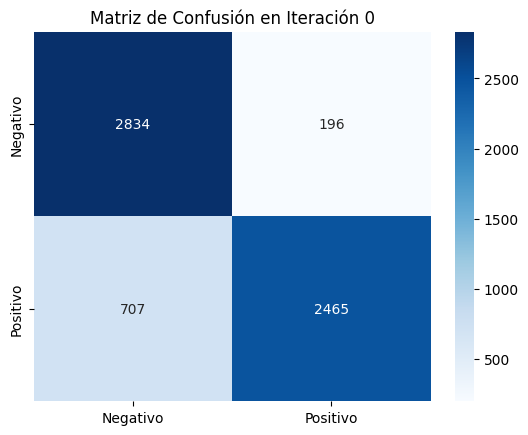

[I 2024-12-06 00:18:59,165] Trial 0 finished with value: 0.845191153780216 and parameters: {'n_estimators': 168, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 1: 0.8378332484292749


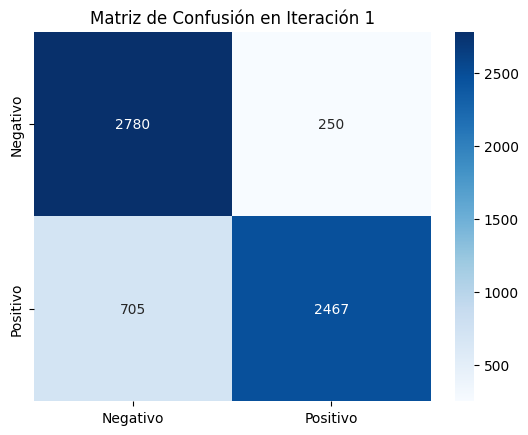

[I 2024-12-06 00:20:30,243] Trial 1 finished with value: 0.8378332484292749 and parameters: {'n_estimators': 476, 'max_depth': 22, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 2: 0.7951346655082537


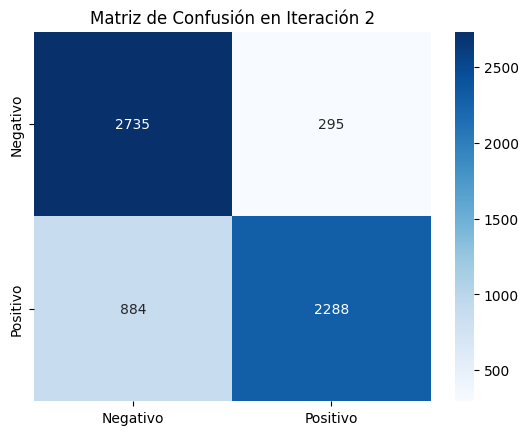

[I 2024-12-06 00:20:34,293] Trial 2 finished with value: 0.7951346655082537 and parameters: {'n_estimators': 161, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 3: 0.7478351229650156


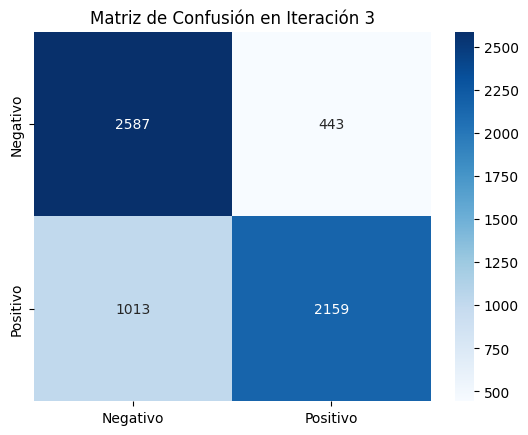

[I 2024-12-06 00:20:36,101] Trial 3 finished with value: 0.7478351229650156 and parameters: {'n_estimators': 164, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 4: 0.7445154603558473


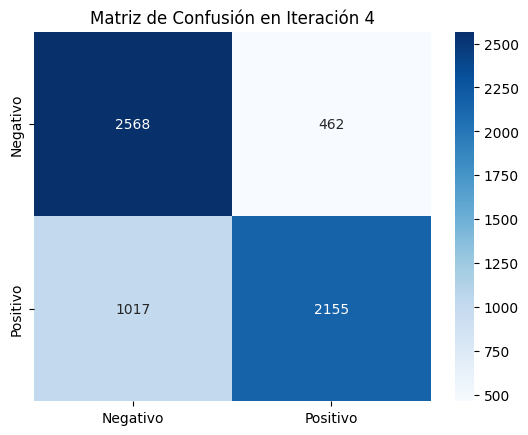

[I 2024-12-06 00:20:39,001] Trial 4 finished with value: 0.7445154603558473 and parameters: {'n_estimators': 290, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 5: 0.830959327269607


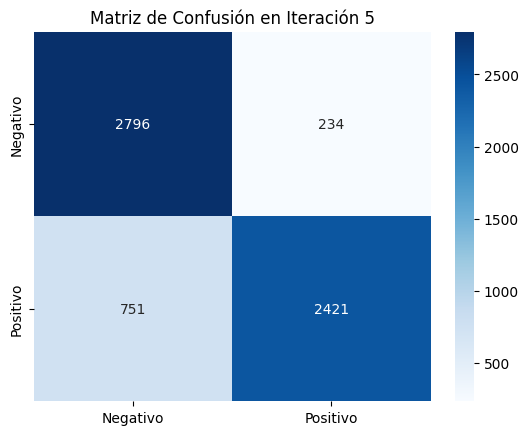

[I 2024-12-06 00:20:41,469] Trial 5 finished with value: 0.830959327269607 and parameters: {'n_estimators': 66, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 6: 0.8391370817054526


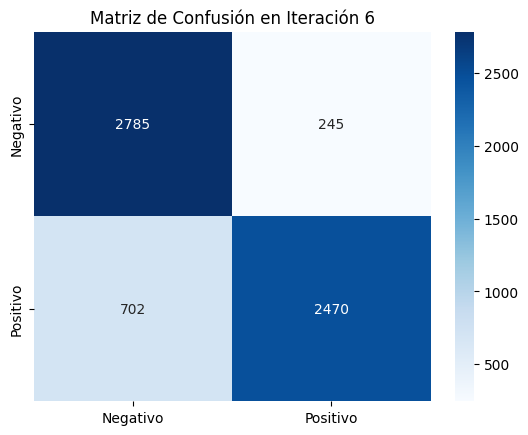

[I 2024-12-06 00:21:59,823] Trial 6 finished with value: 0.8391370817054526 and parameters: {'n_estimators': 398, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': None}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 7: 0.8284432171211599


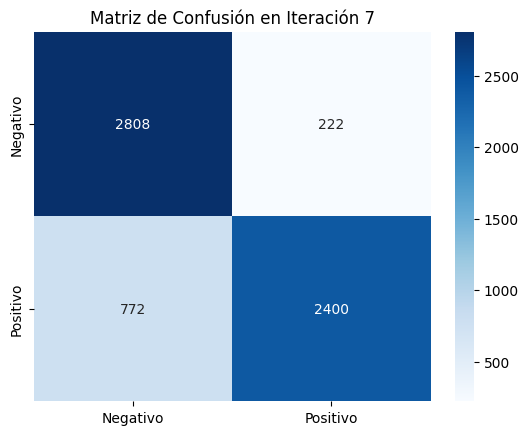

[I 2024-12-06 00:22:07,182] Trial 7 finished with value: 0.8284432171211599 and parameters: {'n_estimators': 308, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 8: 0.7528635890315862


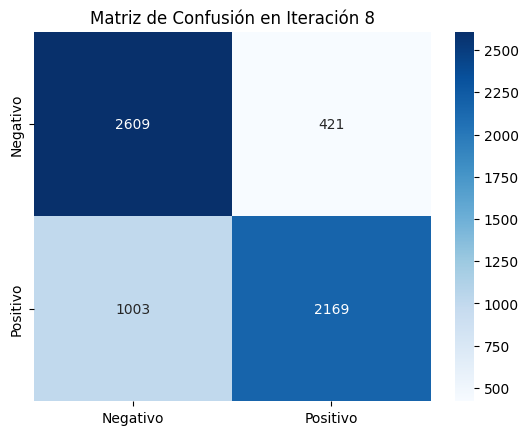

[I 2024-12-06 00:22:12,173] Trial 8 finished with value: 0.7528635890315862 and parameters: {'n_estimators': 497, 'max_depth': 8, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.845191153780216.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 9: 0.8470869639501111


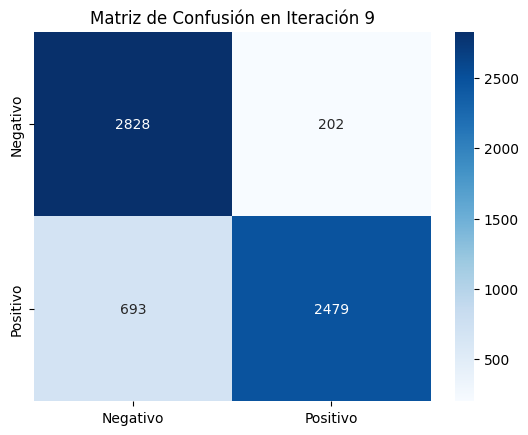

[I 2024-12-06 00:23:17,676] Trial 9 finished with value: 0.8470869639501111 and parameters: {'n_estimators': 319, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 9 with value: 0.8470869639501111.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 10: 0.8702264837163167


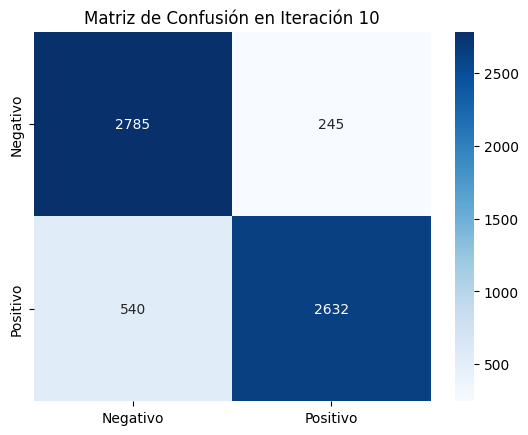

[I 2024-12-06 00:24:46,182] Trial 10 finished with value: 0.8702264837163167 and parameters: {'n_estimators': 368, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 10 with value: 0.8702264837163167.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 11: 0.8695077634621737


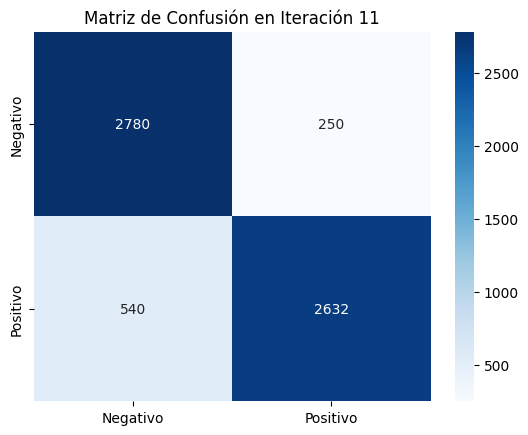

[I 2024-12-06 00:26:30,250] Trial 11 finished with value: 0.8695077634621737 and parameters: {'n_estimators': 377, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 10 with value: 0.8702264837163167.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 12: 0.8704132231404959


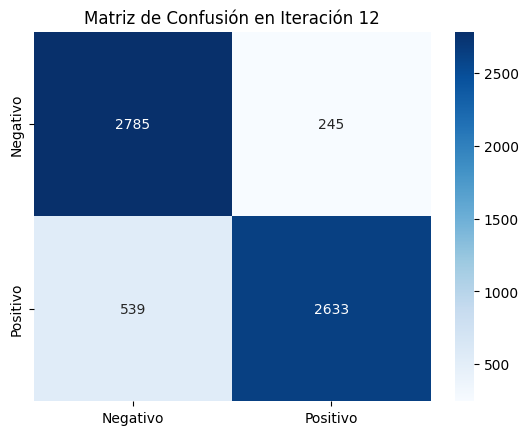

[I 2024-12-06 00:28:21,245] Trial 12 finished with value: 0.8704132231404959 and parameters: {'n_estimators': 391, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 13: 0.8568565224653416


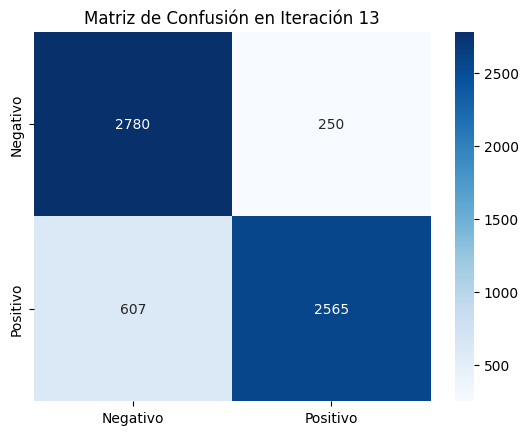

[I 2024-12-06 00:30:03,531] Trial 13 finished with value: 0.8568565224653416 and parameters: {'n_estimators': 405, 'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 14: 0.8666555685034126


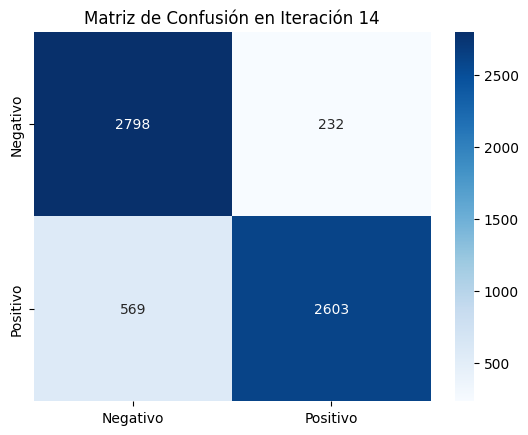

[I 2024-12-06 00:32:01,256] Trial 14 finished with value: 0.8666555685034126 and parameters: {'n_estimators': 427, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 15: 0.847252562594522


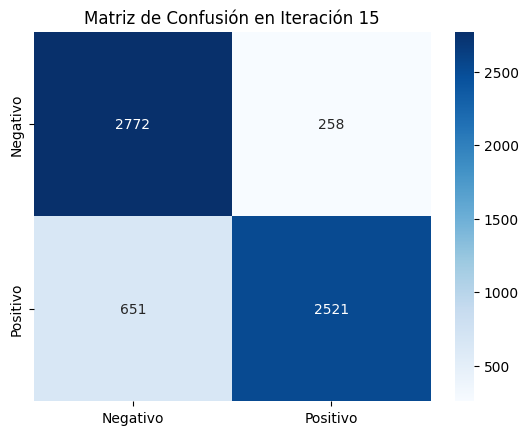

[I 2024-12-06 00:32:59,591] Trial 15 finished with value: 0.847252562594522 and parameters: {'n_estimators': 228, 'max_depth': 26, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 16: 0.8606242697379403


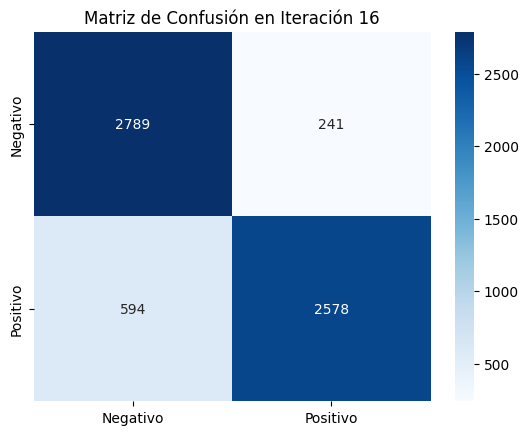

[I 2024-12-06 00:34:32,313] Trial 16 finished with value: 0.8606242697379403 and parameters: {'n_estimators': 342, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 17: 0.8241397198685804


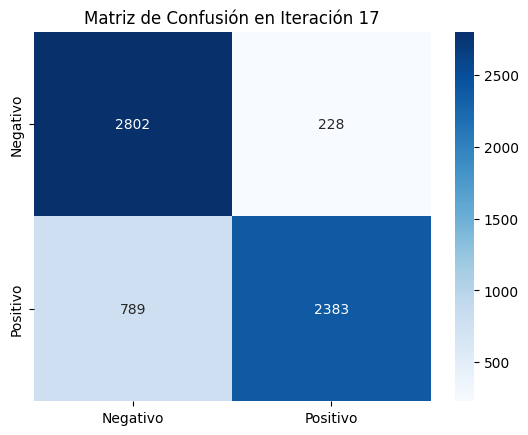

[I 2024-12-06 00:35:15,718] Trial 17 finished with value: 0.8241397198685804 and parameters: {'n_estimators': 230, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 18: 0.8678559629996696


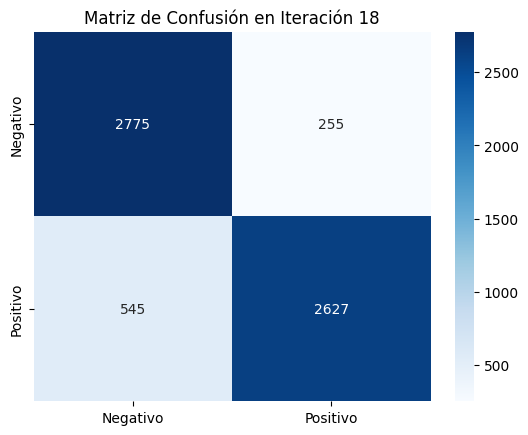

[I 2024-12-06 00:37:04,091] Trial 18 finished with value: 0.8678559629996696 and parameters: {'n_estimators': 450, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 19: 0.8496420047732697


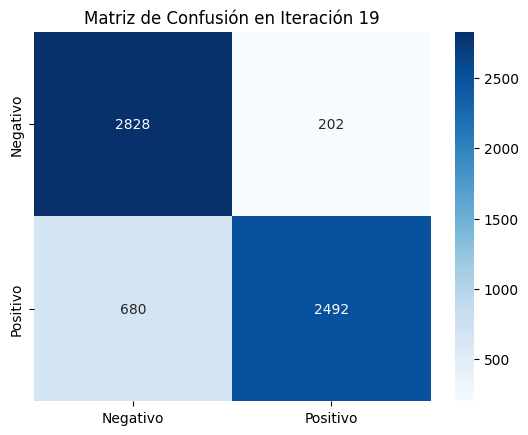

[I 2024-12-06 00:37:16,928] Trial 19 finished with value: 0.8496420047732697 and parameters: {'n_estimators': 359, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 score en iteración 20: 0.8420153714773698


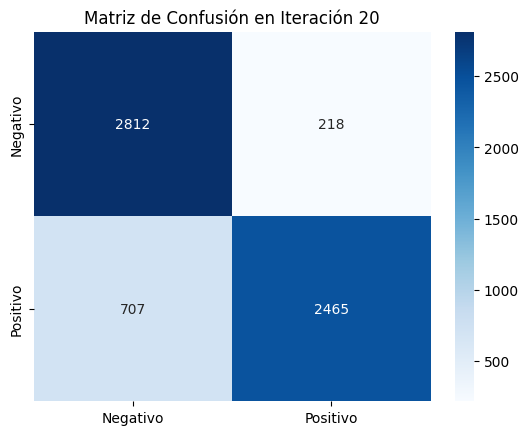

[I 2024-12-06 00:38:00,030] Trial 20 finished with value: 0.8420153714773698 and parameters: {'n_estimators': 232, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 12 with value: 0.8704132231404959.
c:\Users\diego\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna


# Definir las columnas
ys = ['target']
binary_columns = ['market_ht_trendmode', 'unique_borrow_protocol_count', 'unique_lending_protocol_count']
id_columns = ['borrow_block_number']
wallet = ['wallet_address']
time_columns = [
    'risky_first_tx_timestamp', 'risky_last_tx_timestamp', 'risky_first_last_tx_timestamp_diff',
    'time_since_first_deposit', 'time_since_last_liquidated','borrow_timestamp', 'first_tx_timestamp', 'last_tx_timestamp']

# Columnas a escalar
columns_to_scale = list(X0.columns.difference(id_columns + binary_columns + time_columns + ys + wallet))

# Preprocesador para escalar las columnas necesarias y pasar a través las demás
preprocessor = ColumnTransformer(
    transformers=[ 
        ('scaler', StandardScaler(), columns_to_scale),
        ('passthrough', 'passthrough', id_columns + binary_columns + time_columns)
    ]
)

# Dividir en conjunto de entrenamiento (train) y conjunto de prueba (test)
X_train, X_test, y_train, y_test = train_test_split(X0, y0, test_size=0.3, stratify=y0, random_state=17)

# Ahora, dividir el conjunto de entrenamiento (X_train, y_train) en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=17)

y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

# Verificar tamaños de los conjuntos
print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}")
print(f"Tamaño del conjunto de validación: {X_val.shape[0]}")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]}")

# Función para crear el pipeline con parámetros configurables
def create_pipeline(model):
    return Pipeline([
        ('preprocessing', preprocessor),  # Preprocesamiento
        ('model', model)  # Modelo
    ])

# Modelo inicial
initial_model = ExtraTreesClassifier(random_state=123)
initial_pipeline = create_pipeline(initial_model)

# Entrenar el modelo inicial sin optimización de parámetros
initial_pipeline.fit(X_train, y_train)

# Evaluación inicial en el conjunto de test
initial_y_pred = initial_pipeline.predict(X_test)
initial_f1 = f1_score(y_test, initial_y_pred)
print(f'Rendimiento inicial (F1) en X_test: {initial_f1}')

# Crear la función objetivo para Optuna
def objective(trial):
    # Definir los hiperparámetros a optimizar
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    #max_features=trial.choice(['sqrt', 'log2', None, 0.5, 0.8])
    
    # Definir el modelo ExtraTreesClassifier con los hiperparámetros sugeridos
    model = ExtraTreesClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_split=min_samples_split,
                                 min_samples_leaf=min_samples_leaf,
                                 max_features=max_features,
                                 random_state=123)
    
    # Crear el pipeline
    pipeline = create_pipeline(model)
    
    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    # Realizar predicciones en el conjunto de validación
    y_pred = pipeline.predict(X_val)
    
    # Calcular F1 score en el conjunto de validación
    f1 = f1_score(y_val, y_pred)
    
    # Mostrar el rendimiento durante cada iteración
    print(f'F1 score en iteración {trial.number}: {f1}')
    
    # Mostrar matriz de confusión durante cada iteración
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.title(f'Matriz de Confusión en Iteración {trial.number}')
    plt.show()

    return f1  # Queremos maximizar F1

# Configurar y ejecutar el estudio Optuna
study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=200)  

# Mejor conjunto de parámetros encontrados
best_params = study.best_params
print(f'Mejores parámetros encontrados: {best_params}')

# Crear el modelo final con los mejores parámetros
final_model = ExtraTreesClassifier(**best_params, random_state=123)

# Crear el pipeline final con el preprocesador
final_pipeline = create_pipeline(final_model)

# Entrenar el modelo final
final_pipeline.fit(X_train, y_train)

# Guardar el escalador (transformador) para uso posterior
joblib.dump(final_pipeline.named_steps['preprocessing'], 'scaler.pkl')

# Evaluación final en el conjunto de test con la métrica F1
final_y_pred = final_pipeline.predict(X_test)
final_f1 = f1_score(y_test, final_y_pred)
print(f'Rendimiento final (F1) en X_test: {final_f1}')

# Mostrar la matriz de confusión final
final_cm = confusion_matrix(y_test, final_y_pred)
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.title('Matriz de Confusión Final')
plt.show()

# Guardar el pipeline final para uso posterior
joblib.dump(final_pipeline, 'final_pipeline.pkl')

## Gráfico de coordenadas paralelas

In [ ]:
# Recopilar los resultados de la optimización
trials = study.trials
results = []

# Obtener los parámetros y el score F1 de cada trial
for trial in trials:
    params = trial.params
    f1_score = trial.value
    results.append({**params, 'f1_score': f1_score})

# Crear un DataFrame con los resultados
df_results = pd.DataFrame(results)

# Mostrar los primeros resultados
df_results

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de que los parámetros estén ordenados correctamente
df_results_sorted = df_results.sort_values(by=['n_estimators', 'max_depth'])

# Configura el gráfico de líneas paralelas
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_results_sorted, x="n_estimators", y="f1_score", hue="max_depth", 
             marker="o", linestyle="-", palette="tab10", linewidth=2)

# Personaliza el gráfico
plt.title("Gráfico de Líneas Paralelas: F1 Score vs Parámetros")
plt.xlabel("n_estimators")
plt.ylabel("F1 Score")
plt.legend(title="max_depth", loc="upper right", bbox_to_anchor=(1.1, 1))

# Mostrar el gráfico
plt.show()